Input: Ochre Equipment Reading Output
Trains Regression models based on 15 minute increments of , Node Temp, Draw Data, and Setpoint

In [47]:
#import data
import pandas as pd
import numpy as np

#Data transformation, Y-values are y_i+1 temperatures for the next hour
def rolling_subsets(input_list, window_size = 4):
    if window_size > len(input_list) or window_size <= 0:
        raise ValueError("Window size must be positive and not greater than the list length.")
    
    return [input_list[i*window_size:i*window_size + window_size] for i in range(int(len(input_list)/window_size))]

import numpy as np

def csv_to_features(df): #exports features, y = 15 minute increment predictions for 1 hour of outlet temperature
    #x = 15 minute increment predictions for setpoint and draw data, live readings for node temperature
    #include = True - includes node temperatures, x4/x5
    y_col = df["Hot Water Outlet Temperature (C)"]
    window = 8 #2 hours
    result = rolling_subsets(y_col, window)

    # Create feature vectors
    x1 = df["Hot Water Average Temperature (C)"]
    x2 = rolling_subsets(df["Draw Data (L)"], window)
    x3 = rolling_subsets(df["Setpoint (C)"], window)
    x4 = df["T_WH3 Temperature (C)"]
    x5 = df["T_WH10 Temperature (C)"]

    print(len(result), len(x2), len(x3))

    y = result[:-1]  # Remove the first index to offset, y = i+1th prediction
    #x1_v = x1[:-window]  # average temperature
    x2_v = x2[:-1] #draw values
    x3_v = x3[:-1] #setpoint values
    x4_v = x4[:-window - 2:window] #note temperatures should only be taken at current time interval (live readings)
    x5_v = x5[:-window - 2:window]

    print(len(y) , len(x2_v), len(x3_v), len(x4_v))

    # Stack features
    X = np.column_stack([x2_v, x3_v, x4_v, x5_v]) #Node 10 x5_v

    return X, y


In [48]:
#data = pd.read_csv("output_site_10292.csv")  90023
#data = pd.read_csv("output_site_90023.csv")
#X, y = csv_to_features(data)

#data1 = pd.read_csv("output_site_null.csv")
#X1, y1 = csv_to_features(data1)

data = pd.read_csv("output_site_large.csv")
X, y = csv_to_features(data)




96357 96357 96357
96356 96356 96356 96356


In [49]:
#Train test split 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train,y_train)
r_sq = model.score(X_train, y_train)
print(f"Training coefficient of determination: {r_sq}")
y_predict = model.predict(X_test)
test_r_sq = model.score(X_test, y_test)
print(f"Test coefficient of determination: {test_r_sq}")
mse = mean_squared_error(y_test, y_predict, multioutput='uniform_average')
print("Mean Squared Error:", mse)

Training coefficient of determination: 0.9149183793902793
Test coefficient of determination: 0.9152738359655068
Mean Squared Error: 0.5408334336797931


In [50]:
model.coef_

array([[ 5.77106624e-04,  1.35884619e-04,  1.54111576e-04,
         4.44908146e-05,  7.65501720e-05, -1.35837901e-04,
         8.20475826e-06,  5.61466648e-05,  3.97055516e-03,
        -4.13884250e-03,  2.77171982e-03, -2.05354859e-03,
         3.33964292e-03, -4.45616447e-03,  2.82781951e-03,
        -1.02815245e-03,  9.97157873e-01,  9.65984659e-04],
       [ 3.48558185e-03,  2.37982862e-03,  1.85334251e-03,
         1.16867660e-03, -1.83372042e-04, -6.10628814e-04,
        -9.41060435e-04, -1.09940387e-03,  2.59823487e-02,
         3.71800413e-03, -1.85296031e-02,  2.63628373e-02,
        -4.12915121e-03, -2.50870457e-02,  3.17477578e-02,
        -2.07142102e-02,  9.81074559e-01,  1.82410362e-03],
       [ 7.05158500e-03,  3.37982306e-03,  2.34586750e-03,
         3.46258728e-04, -1.16028383e-03, -8.73625391e-04,
        -1.06233348e-03, -1.66434003e-03,  3.49899300e-02,
         5.98220330e-03, -3.79082332e-03,  2.03185059e-02,
         2.49185578e-02, -7.04430138e-02,  6.62927140e

In [52]:
i = 96 + 8 

print("Input: ")
print(X_test[i])
print("Hot Water Outlet: ")
print(y_test[i])

print("Predicted Hot Water Outlet Temperature: " ) 
y_predict[i]

Input: 
[ 0.          0.          0.          0.          0.          0.
  0.          0.         55.46533333 58.06       58.06       58.06
 55.09466667 52.5        52.5        52.5        54.47586673 51.86356053]
Hot Water Outlet: 
258400    54.566487
258401    54.444266
258402    54.323418
258403    54.203910
258404    54.085708
258405    54.237528
258406    54.209686
258407    54.090320
Name: Hot Water Outlet Temperature (C), dtype: float64
Predicted Hot Water Outlet Temperature: 


array([54.42840854, 54.54586842, 54.68468018, 54.77999596, 54.83702585,
       54.79955636, 54.72120692, 54.6000745 ])

In [53]:
# get coefficients of model
#pd.DataFrame(zip(X_train.columns, model.coef_))
model.coef_

array([[ 5.77106624e-04,  1.35884619e-04,  1.54111576e-04,
         4.44908146e-05,  7.65501720e-05, -1.35837901e-04,
         8.20475826e-06,  5.61466648e-05,  3.97055516e-03,
        -4.13884250e-03,  2.77171982e-03, -2.05354859e-03,
         3.33964292e-03, -4.45616447e-03,  2.82781951e-03,
        -1.02815245e-03,  9.97157873e-01,  9.65984659e-04],
       [ 3.48558185e-03,  2.37982862e-03,  1.85334251e-03,
         1.16867660e-03, -1.83372042e-04, -6.10628814e-04,
        -9.41060435e-04, -1.09940387e-03,  2.59823487e-02,
         3.71800413e-03, -1.85296031e-02,  2.63628373e-02,
        -4.12915121e-03, -2.50870457e-02,  3.17477578e-02,
        -2.07142102e-02,  9.81074559e-01,  1.82410362e-03],
       [ 7.05158500e-03,  3.37982306e-03,  2.34586750e-03,
         3.46258728e-04, -1.16028383e-03, -8.73625391e-04,
        -1.06233348e-03, -1.66434003e-03,  3.49899300e-02,
         5.98220330e-03, -3.79082332e-03,  2.03185059e-02,
         2.49185578e-02, -7.04430138e-02,  6.62927140e

In [8]:
error = (y_test[0] - y_predict[0]) / y_test[0]
#np.sum(error)/len(error)
error


46669   -0.016614
46670   -0.017186
46671   -0.014338
46672   -0.015125
Name: Hot Water Outlet Temperature (C), dtype: float64

In [54]:
#validation test
#val_data = pd.read_csv("output_site_10441.csv")
val_data = pd.read_csv("output_site_90023.csv")
#val_data = pd.read_csv("output_site_null.csv")
X_val, y_val = csv_to_features(val_data)

105600 105600 105600
105599 105599 105599 105599


In [55]:
#error metrics
from sklearn.metrics import r2_score
y_predict_val = model.predict(X_val)

r_2_val = r2_score(y_val, y_predict_val)
print(f"test coefficient of determination: {r_2_val}")

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, y_predict_val, multioutput='uniform_average')
print("Mean Squared Error:", mse)

test coefficient of determination: 0.918650453749873
Mean Squared Error: 2.250991740597205


In [82]:
i = 12 * 25 +8
print("Input: ")
print(X_val[i])
print("Hot Water Outlet: ")
print(y_val[i])

print("Predicted Hot Water Outlet Temperature: " ) 
y_predict_val[i]




Input: 
[ 0.25236067  0.757082    0.25236067  0.          1.26180333  0.25236067
  0.          0.         40.         40.         40.         42.96533333
 45.56       45.56       45.56       42.59466667 33.40343136 21.37434776]
Hot Water Outlet: 
2464    40.213136
2465    37.887561
2466    37.141908
2467    37.034049
2468    45.923305
2469    45.102982
2470    44.978612
2471    44.855355
Name: Hot Water Outlet Temperature (C), dtype: float64
Predicted Hot Water Outlet Temperature: 


array([33.37068575, 33.48544573, 33.71459066, 33.98708157, 34.33052654,
       34.72695115, 35.14916737, 35.5936625 ])

C:\Users\janel\AppData\Local\Temp\ipykernel_35152\2905294263.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Adjust values as needed


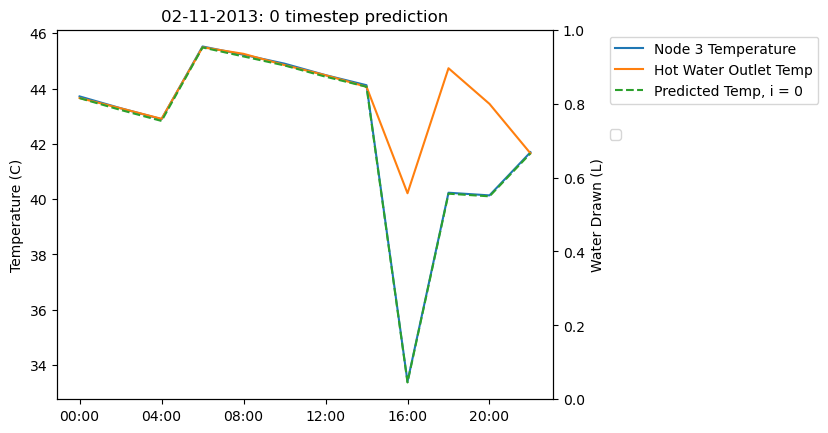

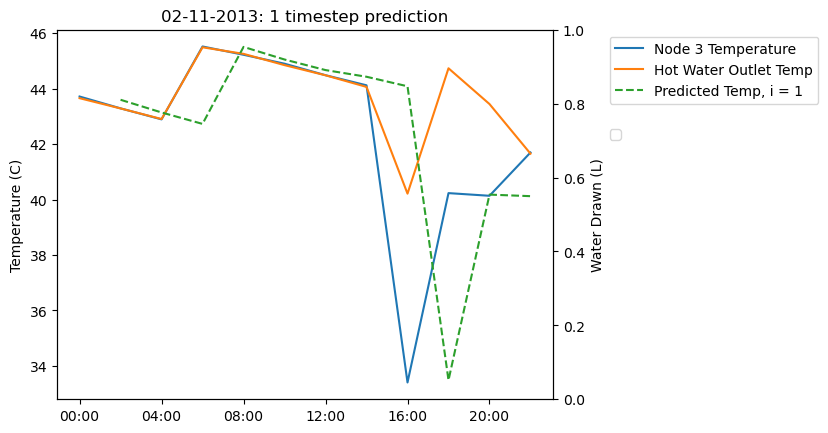

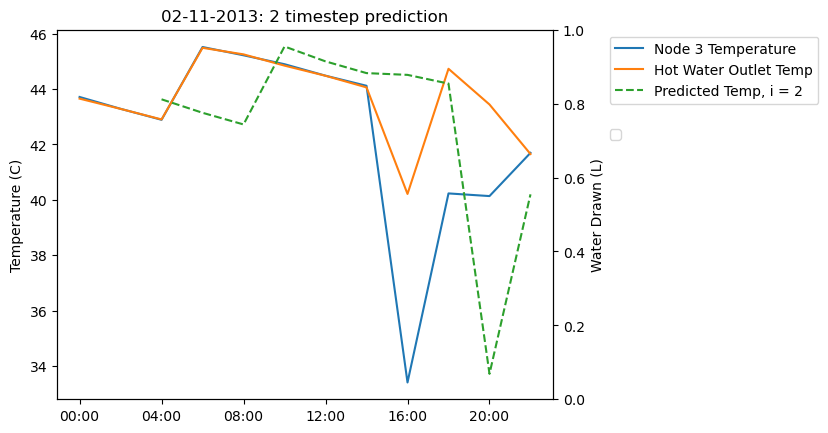

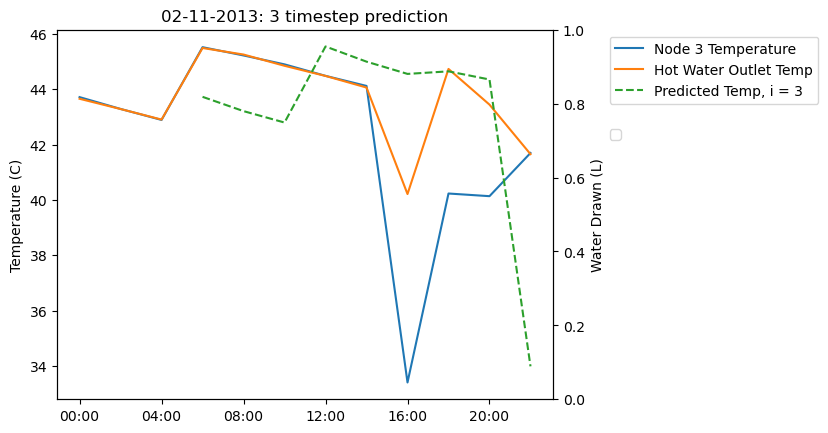

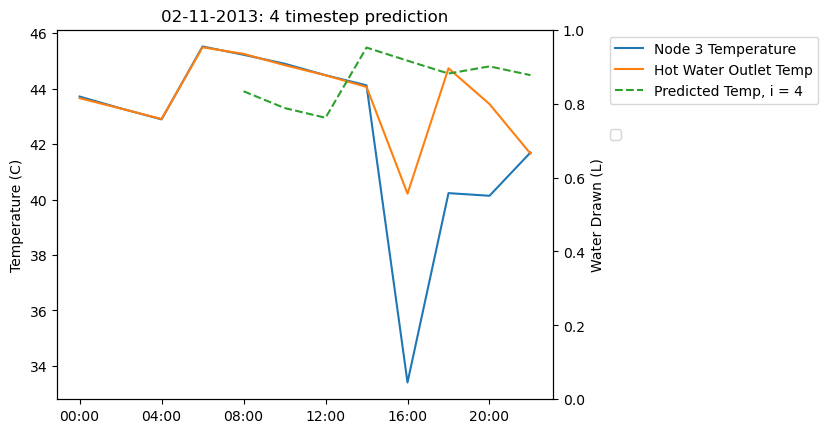

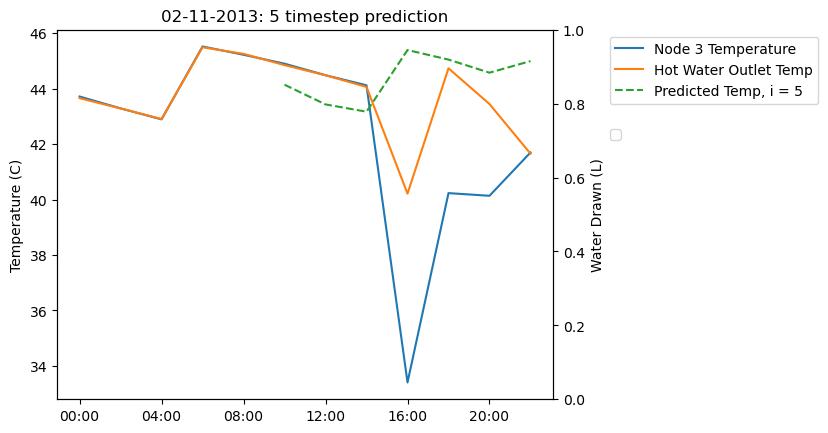

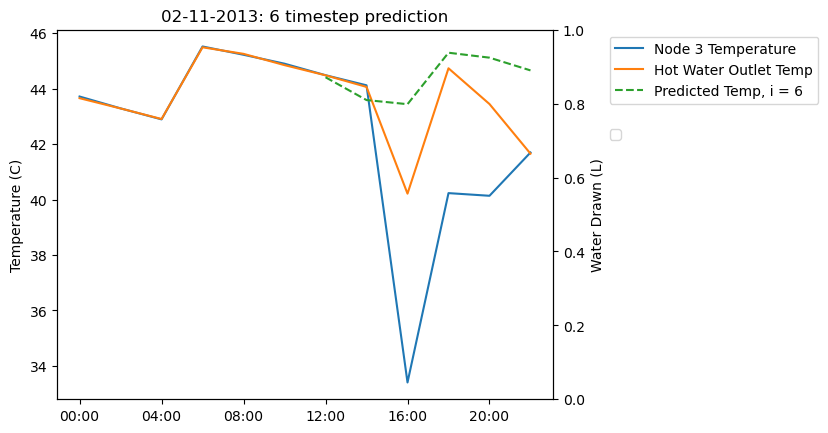

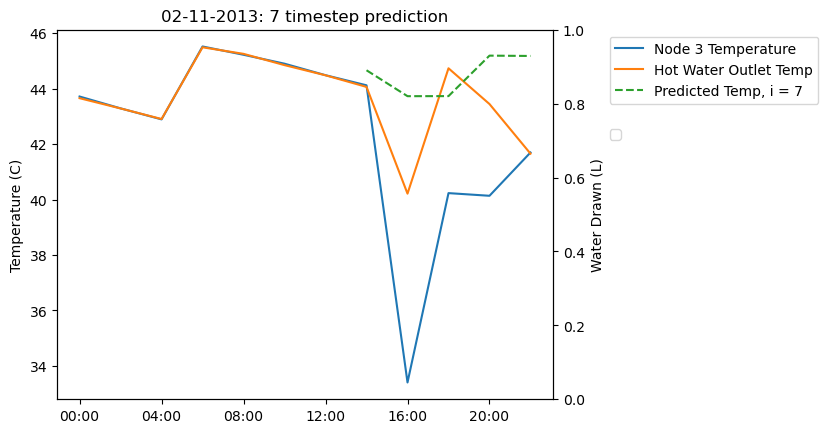

In [79]:
import matplotlib.pyplot as plt
#Create validation graphics

#get data for 1 day
#1440 minutes in a day / 15 = 96 windows in a day
days = {25}
i = 8
intervals = int(1440 / (15 * 8))
for time_i in range(i):
    for day in days:
        x_day = X_val[(intervals*day):(intervals* day) + intervals]
        #avg_temp_day = x_day[:, 0]
        draw_data_day = x_day[:, 0]
        setpoint_day = x_day[:, 8]
        node_3_temp_day = x_day[:, -2]
        node_10_temp_day = x_day[:, -1]
        y_day = y_val[(intervals * day):(intervals * day) + intervals]
        y_day = [list(row) for row in zip(*y_day)]
        y_day = y_day[0]
        y_predict_day = y_predict_val[(intervals * day):(intervals * day) + intervals]
        y_predict_day = y_predict_day[:, time_i]



    
        from datetime import datetime, timedelta
        

        #start_time = "00:00:00"
        start_time = datetime(2013, 1, 1, 0, 0, 0)
        #start_time = datetime.strptime(start_time, "%H:%M:%S")
        #end_time = "23:59:59"
        end_time = datetime(2013, 1, 1, 23, 59, 59)
        # Create datetime range with 15-minute intervals
        datetime_list = pd.date_range(start=start_time, end=end_time, freq="2h")

        # Convert to a list (optional)
        datetime_list = list(datetime_list)
        datetime_list = [dt.strftime("%H:%M") for dt in datetime_list]

        # initializing day number

        
        day_num = str((day + 17) % 365)
        
        # adjusting day num
        day_num.rjust(3 + len(day_num), '0')
        
        # Initialize year
        year = "2013"
        
        # converting to date
        res = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")
        

        import matplotlib.dates as mdates
        plt.figure()
        #plt.plot(datetime_list, avg_temp_day, label = "Hot Water Avg Temp") #avg temp
        #plt.plot(datetime_list, setpoint_day, label = "Setpoint")
        plt.plot(datetime_list, node_3_temp_day, label = "Node 3 Temperature")
        #plt.plot(datetime_list, node_10_temp_day, label = "Node 10 Temperature")
        plt.plot(datetime_list, y_day, label = "Hot Water Outlet Temp")
        if time_i > 0:
            plt.plot(datetime_list[time_i:], y_predict_day[:-time_i], label = f"Predicted Temp, i = {time_i}", linestyle="dashed") #todo: add stagger of 15 minutes
        else:
            plt.plot(datetime_list, y_predict_day, label = f"Predicted Temp, i = {time_i}", linestyle="dashed") #todo: add stagger of 15 minutes
    
        plt.ylabel("Temperature (C)")
        plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))  # Adjust values as needed
        

        plt.twinx()
        #plt.plot(datetime_list, draw_data_day, label="Draw Data", color="blue", linestyle="dotted")
        plt.ylabel("Water Drawn (L)")
    
        plt.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Adjust values as needed

        plt.title(str(res)+ f": {time_i} timestep prediction")

        plt.xticks(datetime_list[::2])
        #plt.legend(loc='lower right')


In [76]:
intervals


12.0

C:\Users\janel\AppData\Local\Temp\ipykernel_28148\3873029130.py:34: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")


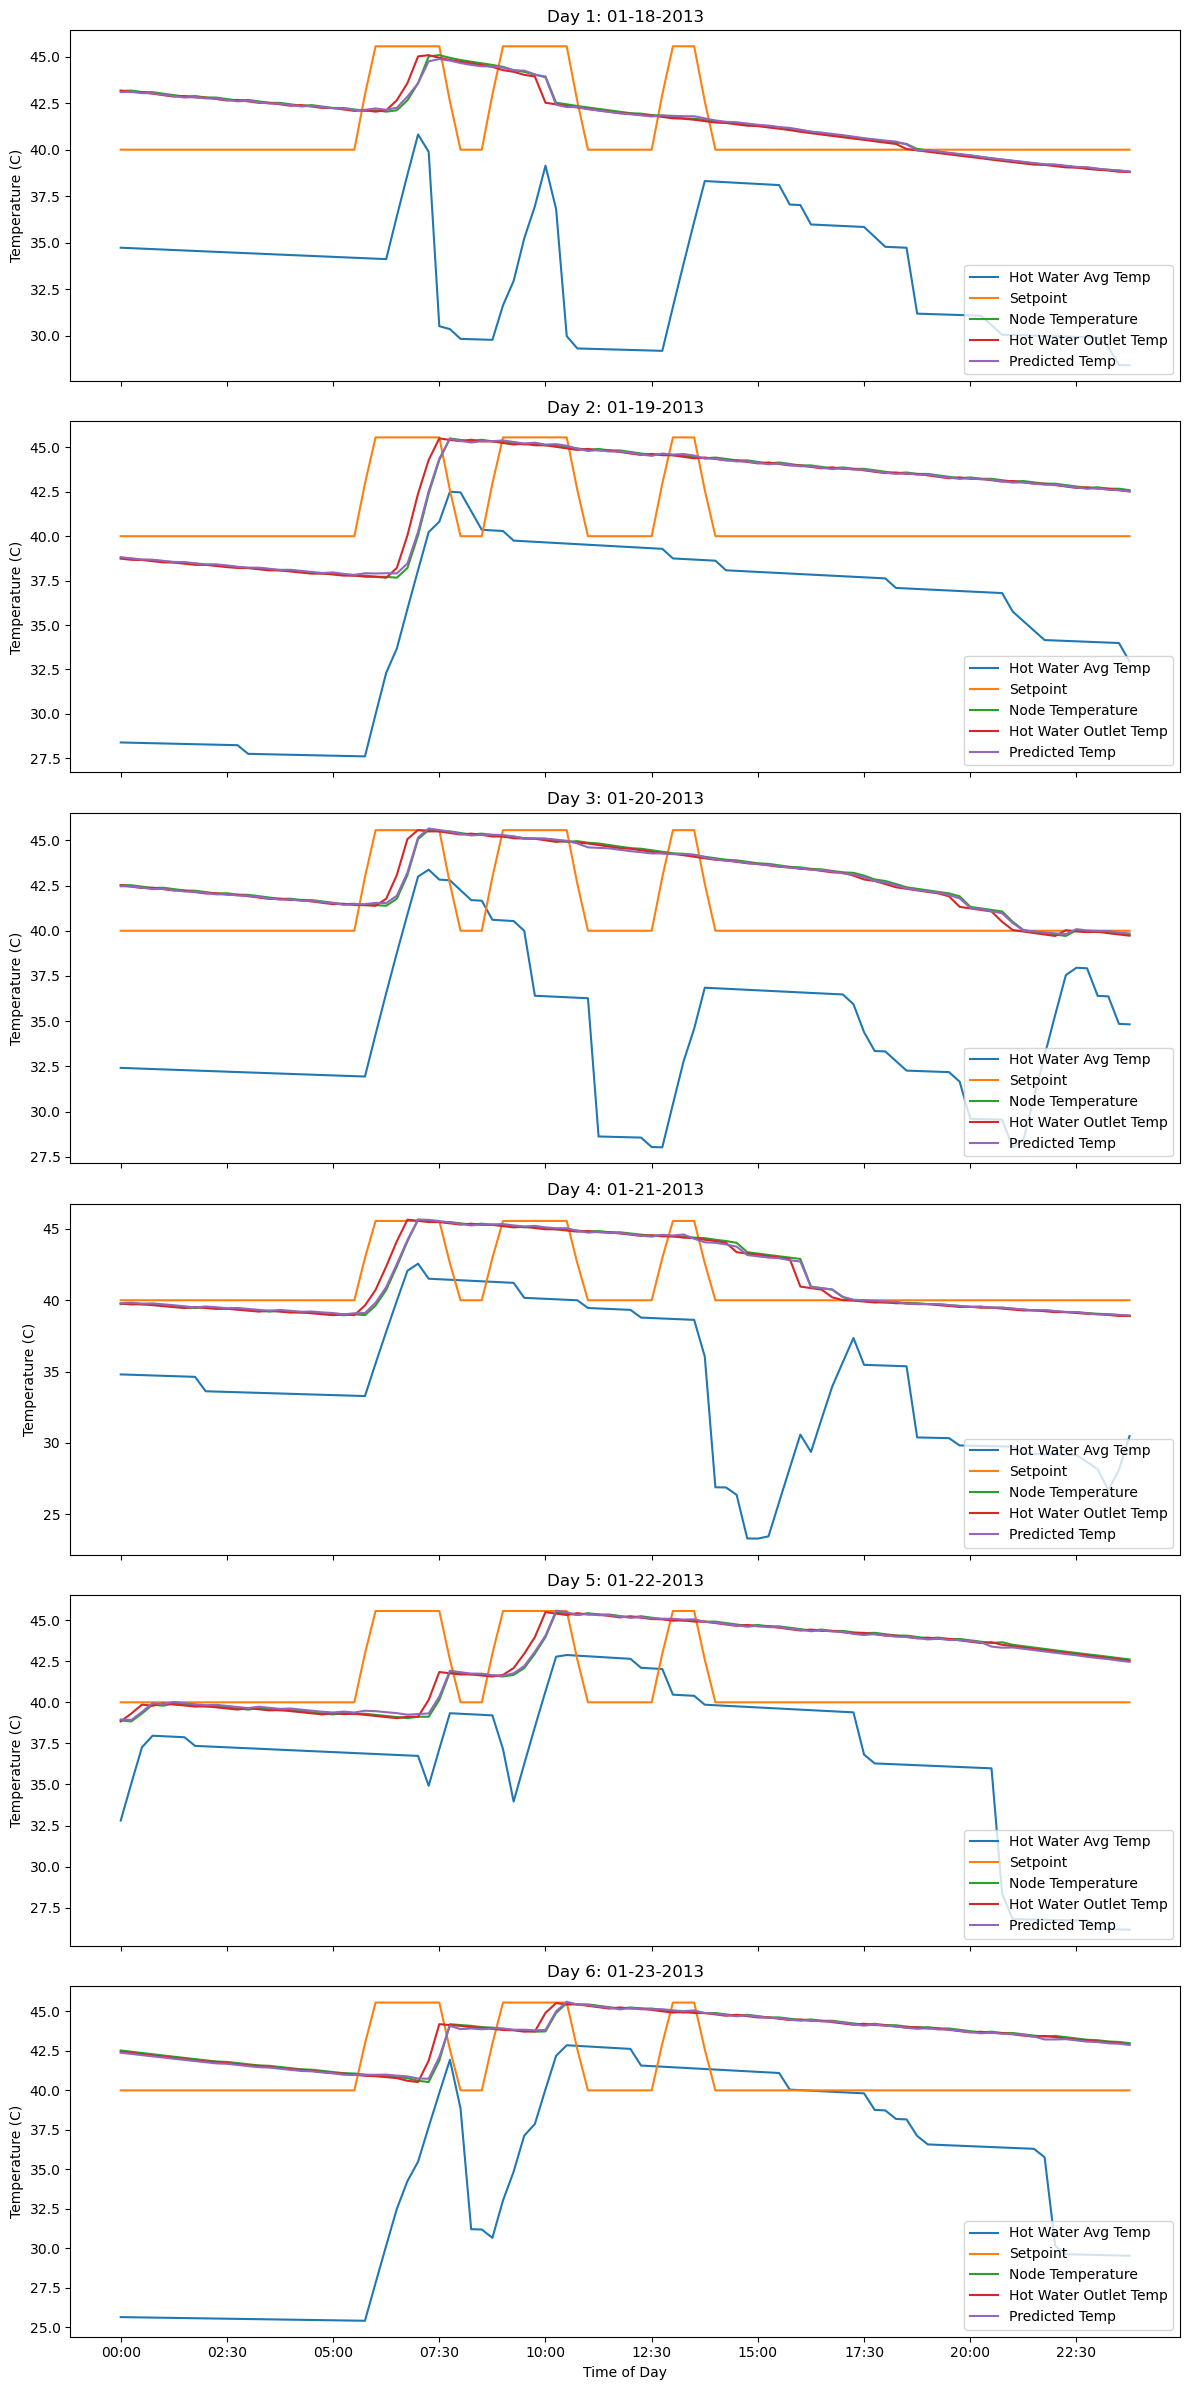

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime

# Define the days to visualize
days = {1, 2, 3, 4, 5, 6}

# Create a figure with subplots (rows for each day)
fig, axes = plt.subplots(len(days), 1, figsize=(12, 4 * len(days)), sharex=True)

# Ensure axes is always iterable (even for a single subplot)
if len(days) == 1:
    axes = [axes]

for i, day in enumerate(days):
    x_day = X_val[(96 * day):(96 * day) + 96]
    avg_temp_day = x_day[:, 0]
    draw_data_day = x_day[:, 1]
    setpoint_day = x_day[:, 5]
    node_temp_day = x_day[:, 9]

    y_day = y_val[(96 * day):(96 * day) + 96]
    y_day = [list(row) for row in zip(*y_day)]
    y_day = y_day[0]

    y_predict_day = y_predict_val[(96 * day):(96 * day) + 96]
    y_predict_day = y_predict_day[:, 0]

    start_time = "00:00:00"
    end_time = "23:59:59"

    # Create datetime range with 15-minute intervals
    datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")
    datetime_list = [dt.strftime("%H:%M") for dt in datetime_list]

    # Format date for the title
    day_num = str((day + 17) % 365).rjust(3, '0')
    year = "2013"
    res = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")

    # Plot each day's data in a separate row
    ax = axes[i]
    ax.plot(datetime_list, avg_temp_day, label="Hot Water Avg Temp")
    ax.plot(datetime_list, setpoint_day, label="Setpoint")
    ax.plot(datetime_list, node_temp_day, label="Node Temperature")
    ax.plot(datetime_list, y_day, label="Hot Water Outlet Temp")
    ax.plot(datetime_list, y_predict_day, label="Predicted Temp")

    ax.set_title(f"Day {day}: {res}")
    ax.set_ylabel("Temperature (C)")
    ax.legend(loc="lower right")

# Set common x-axis labels
axes[-1].set_xticks(datetime_list[::10])
axes[-1].set_xlabel("Time of Day")

# Improve layout
plt.tight_layout()
plt.show()


In [ ]:
# We set Hot Water Outlet as our predicted value
import numpy as np
from sklearn.linear_model import LinearRegression

#Linear Regression
model = LinearRegression()
model.fit(X,y)
r_sq = model.score(X, y)
print(f"coefficient of determination: {r_sq}")


coefficient of determination: 0.9860939061394864


In [63]:
from sklearn.linear_model import Lasso
#Lasso 
lasso = Lasso(alpha=1.0) # alpha is the regularization strength
lasso.fit(X, y)
lasso.score(X, y)

0.9857133554804913

In [ ]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(X, y)
clf.score(X, y)

0.9860939061394838

: 

[0.00625460712,
 -0.0417892614,
 0.01450787,
 -0.000148634945,
 -0.00165626542,
 -0.00398750475,
 -0.00401025626,
 -0.00294109852,
 0.888731644,
 -0.00514401545]

In [69]:
M

array([[ 6.25460712e-03, -4.17892614e-02,  1.45078700e-02,
        -1.48634945e-04, -1.65626542e-03, -3.98750475e-03,
        -4.01025626e-03, -2.94109852e-03,  8.88731644e-01,
        -5.14401545e-03],
       [ 2.77638753e-02, -1.05860217e-01, -2.05706913e-02,
         1.18870177e-02, -3.16097290e-04, -2.91305429e-03,
        -4.44793805e-03, -2.90759753e-03,  8.62335223e-01,
        -1.88669920e-03],
       [ 1.51693643e-02, -9.01459209e-02, -8.54562993e-02,
        -2.29734523e-02,  1.15367862e-02, -1.38193182e-03,
        -2.81366406e-03, -3.30682336e-03,  8.33101551e-01,
        -6.40011120e-04],
       [ 1.45554257e-02, -1.02992719e-01, -7.26927208e-02,
        -8.71559240e-02, -2.41501580e-02,  1.04887660e-02,
        -9.67297381e-04, -1.65804673e-03,  8.04262858e-01,
        -6.13514419e-04],
       [ 1.59764637e-02, -1.01098912e-01, -8.60682054e-02,
        -7.30539695e-02, -8.91306653e-02, -2.41711655e-02,
         9.82865577e-03,  9.01233712e-04,  7.76249087e-01,
        -1.

Model Coefficients: 
        [6.25460712e-03, -4.17892614e-02,  1.45078700e-02,
        -1.48634945e-04, -1.65626542e-03, -3.98750475e-03,
        -4.01025626e-03, -2.94109852e-03,  5.57711947e-02,
        -4.12871628e-03, -1.92634527e-02,  2.89880654e-02,
         1.03839646e-02,  4.27543933e-03, -2.30155374e-02,
         3.62389037e-02,  8.88731644e-01, -5.14401545e-03],
       [ 2.77638753e-02, -1.05860217e-01, -2.05706913e-02,
         1.18870177e-02, -3.16097290e-04, -2.91305429e-03,
        -4.44793805e-03, -2.90759753e-03,  5.82682483e-02,
         8.68213266e-03, -1.62680675e-03,  1.01281922e-02,
         2.56916233e-02, -3.15834816e-03, -2.10446746e-02,
         3.55276442e-02,  8.62335223e-01, -1.88669920e-03],
       [ 1.51693643e-02, -9.01459209e-02, -8.54562993e-02,
        -2.29734523e-02,  1.15367862e-02, -1.38193182e-03,
        -2.81366406e-03, -3.30682336e-03,  7.02235590e-02,
        -5.10075210e-03,  2.07881191e-02,  2.28335826e-02,
         1.54431650e-02,  3.10435917e-03, -2.40048971e-02,
         3.66494045e-02,  8.33101551e-01, -6.40011120e-04],
       [ 1.45554257e-02, -1.02992719e-01, -7.26927208e-02,
        -8.71559240e-02, -2.41501580e-02,  1.04887660e-02,
        -9.67297381e-04, -1.65804673e-03,  6.88879367e-02,
         9.19088439e-03,  5.36748804e-03,  4.70129494e-02,
         2.61752238e-02, -5.04828100e-03, -1.96994873e-02,
         3.59765419e-02,  8.04262858e-01, -6.13514419e-04],
       [ 1.59764637e-02, -1.01098912e-01, -8.60682054e-02,
        -7.30539695e-02, -8.91306653e-02, -2.41711655e-02,
         9.82865577e-03,  9.01233712e-04,  7.23084279e-02,
         1.39040304e-03,  2.46988117e-02,  2.73744080e-02,
         5.47915173e-02,  1.55808149e-03, -2.48843906e-02,
         3.84811029e-02,  7.76249087e-01, -1.34175681e-03],
       [ 1.09900244e-02, -9.31684910e-02, -8.61747063e-02,
        -8.74173110e-02, -7.58464384e-02, -8.87446600e-02,
        -2.55574887e-02,  1.35911660e-02,  7.13763518e-02,
         5.28459399e-03,  1.57597437e-02,  4.81736747e-02,
         3.37768118e-02,  3.18487505e-02, -2.12764775e-02,
         3.71605419e-02,  7.50147713e-01, -2.54332914e-03],
       [ 1.18276710e-02, -8.88973975e-02, -7.75248347e-02,
        -8.69995610e-02, -8.98479955e-02, -7.42300517e-02,
        -9.07444324e-02, -1.85131922e-02,  7.31369099e-02,
        -4.88046871e-04,  2.37528100e-02,  3.57408749e-02,
         5.82218647e-02,  7.59767931e-03,  1.14982613e-02,
         3.83875961e-02,  7.25159239e-01, -4.14010272e-03],
       [ 2.61027990e-02, -8.31925185e-02, -7.55482374e-02,
        -8.09662976e-02, -8.88863543e-02, -8.95595424e-02,
        -7.73536288e-02, -9.23762527e-02,  6.82204451e-02,
         7.10422024e-03,  1.44099871e-02,  4.60600721e-02,
         4.21294528e-02,  3.60398764e-02, -1.55777123e-02,
         7.32810268e-02,  7.01950982e-01, -5.62962301e-03]

Heavy draw example:
[ 9.58970533, 10.85150867,  0.50472133,  0.757082  , 40.        ,
       40.        , 40.        , 40.        , 35.62154299, 30.26831141])

In [ ]:
import cvxpy as cp
import numpy as np

i = 8 #horizon
lambda_ = 1
l = 0.75 #soft constraint
n = 8
T_min = 40
T_max = 60

#example value
#model

M = np.array([[6.25460712e-03, -4.17892614e-02,  1.45078700e-02,
        -1.48634945e-04, -1.65626542e-03, -3.98750475e-03,
        -4.01025626e-03, -2.94109852e-03,  5.57711947e-02,
        -4.12871628e-03, -1.92634527e-02,  2.89880654e-02,
         1.03839646e-02,  4.27543933e-03, -2.30155374e-02,
         3.62389037e-02,  8.88731644e-01, -5.14401545e-03],
       [ 2.77638753e-02, -1.05860217e-01, -2.05706913e-02,
         1.18870177e-02, -3.16097290e-04, -2.91305429e-03,
        -4.44793805e-03, -2.90759753e-03,  5.82682483e-02,
         8.68213266e-03, -1.62680675e-03,  1.01281922e-02,
         2.56916233e-02, -3.15834816e-03, -2.10446746e-02,
         3.55276442e-02,  8.62335223e-01, -1.88669920e-03],
       [ 1.51693643e-02, -9.01459209e-02, -8.54562993e-02,
        -2.29734523e-02,  1.15367862e-02, -1.38193182e-03,
        -2.81366406e-03, -3.30682336e-03,  7.02235590e-02,
        -5.10075210e-03,  2.07881191e-02,  2.28335826e-02,
         1.54431650e-02,  3.10435917e-03, -2.40048971e-02,
         3.66494045e-02,  8.33101551e-01, -6.40011120e-04],
       [ 1.45554257e-02, -1.02992719e-01, -7.26927208e-02,
        -8.71559240e-02, -2.41501580e-02,  1.04887660e-02,
        -9.67297381e-04, -1.65804673e-03,  6.88879367e-02,
         9.19088439e-03,  5.36748804e-03,  4.70129494e-02,
         2.61752238e-02, -5.04828100e-03, -1.96994873e-02,
         3.59765419e-02,  8.04262858e-01, -6.13514419e-04],
       [ 1.59764637e-02, -1.01098912e-01, -8.60682054e-02,
        -7.30539695e-02, -8.91306653e-02, -2.41711655e-02,
         9.82865577e-03,  9.01233712e-04,  7.23084279e-02,
         1.39040304e-03,  2.46988117e-02,  2.73744080e-02,
         5.47915173e-02,  1.55808149e-03, -2.48843906e-02,
         3.84811029e-02,  7.76249087e-01, -1.34175681e-03],
       [ 1.09900244e-02, -9.31684910e-02, -8.61747063e-02,
        -8.74173110e-02, -7.58464384e-02, -8.87446600e-02,
        -2.55574887e-02,  1.35911660e-02,  7.13763518e-02,
         5.28459399e-03,  1.57597437e-02,  4.81736747e-02,
         3.37768118e-02,  3.18487505e-02, -2.12764775e-02,
         3.71605419e-02,  7.50147713e-01, -2.54332914e-03],
       [ 1.18276710e-02, -8.88973975e-02, -7.75248347e-02,
        -8.69995610e-02, -8.98479955e-02, -7.42300517e-02,
        -9.07444324e-02, -1.85131922e-02,  7.31369099e-02,
        -4.88046871e-04,  2.37528100e-02,  3.57408749e-02,
         5.82218647e-02,  7.59767931e-03,  1.14982613e-02,
         3.83875961e-02,  7.25159239e-01, -4.14010272e-03],
       [ 2.61027990e-02, -8.31925185e-02, -7.55482374e-02,
        -8.09662976e-02, -8.88863543e-02, -8.95595424e-02,
        -7.73536288e-02, -9.23762527e-02,  6.82204451e-02,
         7.10422024e-03,  1.44099871e-02,  4.60600721e-02,
         4.21294528e-02,  3.60398764e-02, -1.55777123e-02,
         7.32810268e-02,  7.01950982e-01, -5.62962301e-03]]
)


N = [[*ele[8:16]] for ele in M] #Setpoints
N = np.array(N)
M_new = [[*x[0:8], *x[-2:]] for x in M]

M = np.array(M_new)

x = [ 0.        ,  7.82318067,  0.        ,  0.        ,  0.        ,
        0.        ,  9.58970533, 10.85150867, 44.6930026 , 22.10740791]

# Construct the problem.
#declare variables
T = cp.Variable(i)
s = cp.Variable(i) #setpoint variables
z = cp.Variable(i)
objective = cp.Minimize(cp.sum(lambda_ * z**2 + (lambda_*l) * s))

constraints = [
    s >= 49,
    s <= T_max,
    T == M @ x + N @ s,
    z >= T_min - T,
    z >= 0
    ]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Print results
print("Optimal T values:", T.value)
print("Optimal s values:", s.value)
print("Optimal objective value:", result)

Optimal T values: [42.77906181 42.09499094 42.04902835 41.81288997 41.80509277 41.52780884
 40.46536595 39.7194851 ]
Optimal s values: [40. 40. 40. 40. 40. 40. 40. 40.]
Optimal objective value: 240.07868860640394


In [33]:
M = np.array([[ 5.02033259e-04, -9.65960089e-02,  3.79383258e-02,
        -2.79630548e-03, -1.06578162e-02, -2.62974490e-03,
        -1.62293773e-02, -1.58854898e-02,  6.19961250e-02,
        -7.46107579e-03, -1.76866170e-02,  3.14758599e-02,
         1.33327842e-02,  4.74276756e-03, -2.59681146e-02,
         4.45518051e-02,  8.70782356e-01, -6.57375649e-03],
       [ 6.90218954e-02, -1.88578788e-01, -5.44980449e-02,
         2.62819263e-02, -1.18673541e-02, -4.35123554e-03,
        -1.20909190e-02, -1.55621798e-02,  6.27031215e-02,
         8.35032138e-03, -1.16995900e-03,  1.39390782e-02,
         2.74282536e-02,  1.75557649e-04, -2.58885729e-02,
         4.57931375e-02,  8.40114734e-01, -2.90497022e-03],
       [ 6.67691509e-02, -1.28133439e-01, -1.49376163e-01,
        -6.61130950e-02,  1.63260124e-02, -4.90253324e-03,
        -1.40575731e-02, -1.05195144e-02,  7.61838013e-02,
        -9.70924893e-03,  2.50401085e-02,  2.59199957e-02,
         1.80740358e-02,  5.51160526e-03, -2.77962668e-02,
         4.78307867e-02,  8.08004661e-01, -1.68269246e-03],
       [ 6.22399750e-02, -1.28023598e-01, -9.26900324e-02,
        -1.63472254e-01, -7.78586220e-02,  2.46379416e-02,
        -1.55539968e-02, -1.04186021e-02,  7.36515656e-02,
         7.92898866e-03,  3.38722340e-03,  5.53054556e-02,
         2.63462451e-02,  1.88184605e-04, -2.63830818e-02,
         4.99346023e-02,  7.77381289e-01, -1.90305392e-03],
       [ 8.23786058e-02, -1.30324713e-01, -9.91678506e-02,
        -1.06001719e-01, -1.73182725e-01, -6.90892096e-02,
         1.39542652e-02, -1.15842472e-02,  7.75430946e-02,
        -2.10773993e-03,  2.50300648e-02,  3.27443850e-02,
         5.76015138e-02,  5.52603589e-03, -3.16166896e-02,
         5.36261557e-02,  7.49076413e-01, -2.96075247e-03],
       [ 5.52650469e-02, -9.76177770e-02, -1.02600538e-01,
        -1.10696172e-01, -1.15754773e-01, -1.65113700e-01,
        -7.80751515e-02,  1.72807355e-02,  7.75351151e-02,
         5.91261774e-04,  1.46023661e-02,  5.68170644e-02,
         3.25699027e-02,  3.83257383e-02, -2.96548599e-02,
         5.42575289e-02,  7.22943727e-01, -5.03614613e-03],
       [ 7.57462147e-02, -1.20663080e-01, -7.05913666e-02,
        -1.15766430e-01, -1.19340413e-01, -1.05028079e-01,
        -1.77012412e-01, -7.05354048e-02,  7.98889363e-02,
        -5.27567891e-03,  2.13818553e-02,  4.41637695e-02,
         5.85759449e-02,  1.09475775e-02,  4.26554872e-03,
         5.63761914e-02,  6.98542050e-01, -7.15899686e-03],
       [ 8.89766466e-02, -8.65545460e-02, -1.01218173e-01,
        -8.38069676e-02, -1.26084620e-01, -1.16121568e-01,
        -1.16553176e-01, -1.93141582e-01,  7.76080957e-02,
        -1.07939985e-03,  1.36897342e-02,  5.27303265e-02,
         4.35849765e-02,  3.95964757e-02, -2.63540486e-02,
         9.38705224e-02,  6.76120480e-01, -9.31112098e-03]])

features = ["d_0", "d_1", "d_2", "d_3", "d_4", "d_5", "d_6", "d_7", "s_0", "s_1", "s_2", "s_3", "s_4", "s_5", "s_6", "s_7", "T_WH3", "T_WH10" ]
for m in M: 
    rank = np.argsort(m)
    print("Max: ", max(m), " Lowest 3: ", features[rank[0]], features[rank[1]], features[rank[2]] )
    print("Highest 3: ",  features[rank[-3]], features[rank[-2]], features[rank[-1]] )


Max:  0.870782356  Lowest 3:  d_1 s_6 s_2
Highest 3:  s_7 s_0 T_WH3
Max:  0.840114734  Lowest 3:  d_1 d_2 s_6
Highest 3:  s_0 d_0 T_WH3
Max:  0.808004661  Lowest 3:  d_2 d_1 d_3
Highest 3:  d_0 s_0 T_WH3
Max:  0.777381289  Lowest 3:  d_3 d_1 d_2
Highest 3:  d_0 s_0 T_WH3
Max:  0.749076413  Lowest 3:  d_4 d_1 d_3
Highest 3:  s_0 d_0 T_WH3
Max:  0.722943727  Lowest 3:  d_5 d_4 d_3
Highest 3:  s_3 s_0 T_WH3
Max:  0.69854205  Lowest 3:  d_6 d_1 d_4
Highest 3:  d_0 s_0 T_WH3
Max:  0.67612048  Lowest 3:  d_7 d_4 d_6
Highest 3:  d_0 s_7 T_WH3
